In [2]:
!pip install snap-stanford 

You should consider upgrading via the 'c:\users\98ric\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [ ]:
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time

import snap
import seaborn as sns
import pandas as pd

In [2]:
retweets = snap.LoadEdgeList(snap.TNGraph, "Data/higgs-retweet_network.edgelist", 0, 1)
followers = snap.LoadEdgeList(snap.TNGraph, "Data/higgs-social_network.edgelist", 0, 1)
spreading = snap.LoadEdgeList(snap.TNGraph, "Data/spreading.edgelist", 0, 1)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\98ric\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-d50cfae495d9>", line 3, in <module>
    spreading = snap.LoadEdgeList(snap.TNGraph, "Data/spreading.edgelist", 0, 1)
  File "C:\tools\Anaconda3\lib\site-packages\snap\snap.py", line 34067, in LoadEdgeList
    return _LoadEdgeList(GraphType, InFNm, SrcColId, DstColId)
  File "C:\tools\Anaconda3\lib\site-packages\snap\snap.py", line 32435, in LoadEdgeList
    if tspec == PNGraph : return LoadEdgeList_PNGraph(*args)
RuntimeError: Can not open file 'Data/spreading.edgelist'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\98ric\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
Attribute

TypeError: object of type 'NoneType' has no len()

In [7]:
spreading = snap.LoadEdgeList(snap.TNGraph, "Data/spreading_reduced.edgelist", 0, 1)

# PageRank

## Followers

In [4]:
PRankH = followers.GetPageRank() # returns the PageRank for every node 
pageRankList = [] 
for item in PRankH: 
    pageRankList.append([item, PRankH[item]])

dfPageRank = pd.DataFrame(pageRankList,columns=['Node', 'PageRank']) # create df with each node and the corresponding pagerank 
dfPageRank.sort_values(by=['PageRank'], inplace=True, ascending=False); 

In [5]:
dfPageRank.head(5)

,Node,PageRank
0,1,0.015214
1502,1503,0.002804
205,206,0.002742
137,138,0.002548
2054,2055,0.002487


## Spreading

In [8]:
PRankH = spreading.GetPageRank()
pageRankList = []
for item in PRankH:
    pageRankList.append([item, PRankH[item]])

dfPageRank = pd.DataFrame(pageRankList,columns=['Node', 'PageRank'])
dfPageRank.sort_values(by=['PageRank'], inplace=True, ascending=False);

In [1]:
dfPageRank["Node"].head(100)

NameError: name 'dfPageRank' is not defined

# CELF

In [7]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [39]:
cont = 0
def IC(g,S,p=0.5,mc=1000, debug=False):
    global cont
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    if(debug):
        cont += 1
        print("\r", "MC: "+str(cont)+" / "+str(len(g.nodes)), end="")

    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                # get weight of the edges witht the neighborgs

                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(list(g.neighbors(node)))) < [g[node][neighborg]["weight"] for neighborg in g.neighbors(node)]
                new_ones += list(np.extract(success, list(g.neighbors(node))))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [33]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc, debug=True) for node in g.nodes]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(g.nodes, marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g.nodes)], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for step in range(k-1):    

        print("CELF: "+str(step)+" / "+str(k))

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [3]:
import networkx as nx
g_nx = nx.read_edgelist(path="Data/spreading_reduced.edgelist", nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())

In [4]:
len(g_nx.nodes)

19944

In [41]:
# Run algorithm
celf_output   = celf(g_nx, 100, p=0.2, mc = 100)

# Print result
print("celf output:   " + str(celf_output[0]))

 MC: 20032 / 19944CELF: 0 / 100
CELF: 1 / 100
CELF: 2 / 100
CELF: 3 / 100
CELF: 4 / 100
CELF: 5 / 100
CELF: 6 / 100
CELF: 7 / 100
CELF: 8 / 100
CELF: 9 / 100
CELF: 10 / 100
CELF: 11 / 100
CELF: 12 / 100
CELF: 13 / 100
CELF: 14 / 100
CELF: 15 / 100
CELF: 16 / 100
CELF: 17 / 100
CELF: 18 / 100
CELF: 19 / 100
CELF: 20 / 100
CELF: 21 / 100
CELF: 22 / 100
CELF: 23 / 100
CELF: 24 / 100
CELF: 25 / 100
CELF: 26 / 100
CELF: 27 / 100
CELF: 28 / 100
CELF: 29 / 100
CELF: 30 / 100
CELF: 31 / 100
CELF: 32 / 100
CELF: 33 / 100
CELF: 34 / 100
CELF: 35 / 100
CELF: 36 / 100
CELF: 37 / 100
CELF: 38 / 100
CELF: 39 / 100
CELF: 40 / 100
CELF: 41 / 100
CELF: 42 / 100
CELF: 43 / 100
CELF: 44 / 100
CELF: 45 / 100
CELF: 46 / 100
CELF: 47 / 100
CELF: 48 / 100
CELF: 49 / 100
CELF: 50 / 100
CELF: 51 / 100
CELF: 52 / 100
CELF: 53 / 100
CELF: 54 / 100
CELF: 55 / 100
CELF: 56 / 100
CELF: 57 / 100
CELF: 58 / 100
CELF: 59 / 100
CELF: 60 / 100
CELF: 61 / 100
CELF: 62 / 100
CELF: 63 / 100
CELF: 64 / 100
CELF: 65 / 100
CE

## 100 Superspreaders for CELF

[88, 1, 3369, 6948, 407, 7551, 4, 403954, 14549, 301, 10, 339602, 408, 26, 76165, 6241, 83, 965, 35248, 267269, 383, 8756, 232850, 383474, 206362, 15, 1267, 6, 370, 5226, 2, 718, 23318, 138739, 22924, 186, 32, 11889, 2572, 38133, 392560, 50305, 398186, 133418, 8700, 42, 220, 254528, 72203, 51292, 230115, 550, 177829, 7801, 6585, 16801, 5335, 68304, 161272, 28854, 148960, 440391, 45472, 2687, 38819, 154584, 6708, 1250, 87601, 240547, 137329, 67504, 422519, 85434, 341612, 166216, 233404, 43, 154344, 5006, 442735, 128768, 3533, 93977, 144336, 198681, 60035, 4526, 40443, 445734, 400139, 295151, 227432, 154561, 79924, 14431, 67601, 258751, 364011, 349140]

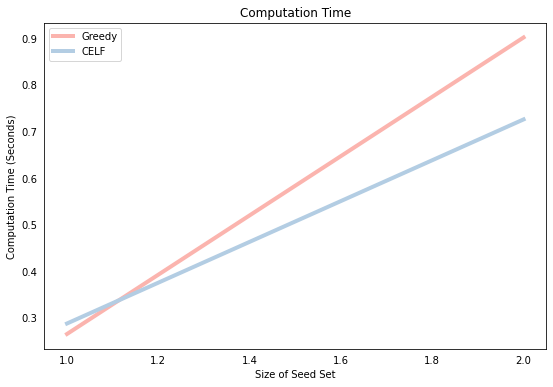

In [61]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);